In [47]:
import time
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, AveragePooling2D, MaxPooling2D, Softmax, GlobalAveragePooling2D, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_score, recall_score, accuracy_score, ConfusionMatrixDisplay
from keras.datasets import cifar10, cifar100, mnist
from keras.applications import ResNet50
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [68]:
def Reshape_2D_to_3D(x1, x2):
    """Функция преобразует 2D массив в 3D в случае необходимости"""
    if len(x1.shape[1:]) > 2:
        return x1, x2
    else:
        x1 = np.expand_dims(x1, axis=3)
        x2 = np.expand_dims(x2, axis=3)
        return x1, x2

def Input_layer(x):
    """Функция формирует входной слой для модели в зависимости от размерности массива"""
    if len(x.shape[1:]) > 2:
        a = x.shape[-1]
    else:
        a = 1
    return Input(shape=(x.shape[1],x.shape[2],a), name='inputs')

def plot_image(i, predictions_array, true_label, img):
    true_label, img = list(y_test[i]).index(1), img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    true_label = list(y_test[i]).index(1)
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')


def recall_precision(y_true, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]):
    recall_precision_dict = {}
    precision = precision_score(y_true, y_pred, labels=labels, average=None)
    recall = recall_score(y_true, y_pred, labels=labels, average=None)
    for i, el in enumerate(zip(precision, recall)):
        recall_precision_dict[f'Класс - {i}'] = [round(el[0],3), round(el[1],3)]
    return recall_precision_dict


def compile_models(Model, X_train, X_test, y_train, y_test, model_batch=350, model_epoch=5, model_metrics='accuracy'):
    """Функция осуществляет подбор наилудчшей модели с несколькими оптимизаторами"""
    print("Start")
    start = time.time()
    result_dict = {}
    X_train, X_test = Reshape_2D_to_3D(X_train, X_test)
    for n1, model in enumerate(Model['models']): # Для каждой модели
        n1 += 1
        for n2, model_optimazer in enumerate(Model['optimizers']): # Для каждого оптимизатора
            n2 += 1
            for n3, loss_i in enumerate(Model['losses']): # Для каждой функции потерь
                n3 += 1
                # Компиляция модели
                print(f'Компиляция модели: Model {n1}  Optimizer {n2}  Loss {n3}  Batch={model_batch}  Epochs={model_epoch}  Metrics={model_metrics}')
                model.compile(optimizer=model_optimazer, loss=loss_i, metrics=[model_metrics])
                # Обучение модели
                print(f'Обучение модели: Model {n1}  Optimizer {n2} Loss {n3}  Batch={model_batch}  Epochs={model_epoch}  Metrics={model_metrics}')
                model.fit(X_train, y_train, batch_size=model_batch, epochs=model_epoch)
                # Оценка модели
                print(f'Оценка модели: Model {n1}  Optimizer {n2}  Loss {n3}  Batch={model_batch}  Epochs={model_epoch}  Metrics={model_metrics}')
                test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=0)
                # Запись результатов оценки модели в словарь
                # Лучшая модель будет определяться по наибольшемы результату метрики accuracy
                print(f'Запись результатов: Model {n1}  Optimizer {n2}  Loss {n3}  Batch={model_batch}  Epochs={model_epoch}  Metrics={model_metrics}')
                print("*"*90)
                result_dict[f'Model_{n1}__Optimizer_{n2}__Loss_{n3}'] = test_acc

    model_keys_list = list(result_dict.keys())
    model_values_list = list(result_dict.values())

    best_accuracy = max(model_values_list)
    count_best_accuracy = model_values_list.count(best_accuracy)

    best_model_dict = {}

    print('Определение наилудчшей модели')
    for acc in range(count_best_accuracy):
        model_keys_list = list(result_dict.keys())
        model_values_list = list(result_dict.values())
        if best_accuracy in model_values_list:
            acc_index = model_values_list.index(best_accuracy)
            best_model_dict[model_keys_list[acc_index]] = best_accuracy
            result_dict.pop(model_keys_list[acc_index])
        else:
            break
    stop = time.time()
    print("Time", stop - start)
    return best_model_dict

## 1 Загрузка датасета

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


### 1.1 Просмотр размера датасета

In [5]:
x_train.shape

(50000, 32, 32, 3)

### 1.2 Просмотр первых 25 изображений

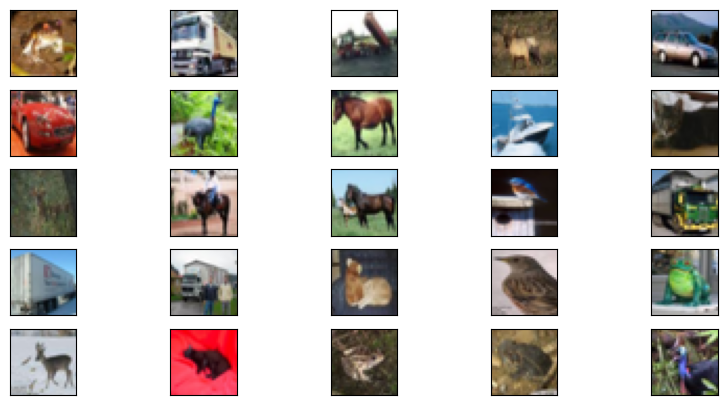

In [6]:
plt.figure(figsize=(10,5))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i])
plt.show()

## 2 нормализация датасета

In [7]:
x_train = x_train / 255
x_test = x_test / 255
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## 3 Формирование архитектуры сети

### 3.1 Создание моделей

In [8]:
MyModel = {}

In [9]:
MyModel = {}

# Формируем общий слой входа для всех моделей
inputs = Input_layer(x_train)

# Модель с использование AveragePooling2D
# Формируем слои для первой модели
x11 = Conv2D(32, (3,3), padding='same', activation='relu', name='x11')(inputs)
x12 = AveragePooling2D(pool_size=(2,2), strides=2, name='x12')(x11)
x13 = Conv2D(64, (3,3), padding='same', activation='relu', name='x13')(x12)
x14 = AveragePooling2D(pool_size=(2,2), strides=2, name='x14')(x13)
x15 = Conv2D(128, (3,3), padding='same', activation='relu', name='x15')(x14)
x16 = AveragePooling2D(pool_size=(2,2), strides=2, name='x16')(x15)
flaten1 = Flatten(name='Flatten')(x16)
x_out11 = Dense(64, activation='relu', name='x17')(flaten1)
x_out12 = Dense(32, activation='relu', name='x18')(x_out11)
x_out13 = Dense(10, name='x19')(x_out12)


# Модель с использование MaxPooling2D
# Формируем слои для второй модели
x21 = Conv2D(32, (3,3), padding='same', activation='relu', name='x21')(inputs)
x22 = MaxPooling2D(pool_size=(2,2), strides=2, name='x22')(x21)
x23 = Conv2D(64, (3,3), padding='same', activation='relu', name='x23')(x22)
x24 = MaxPooling2D(pool_size=(2,2), strides=2, name='x24')(x23)
x25 = Conv2D(128, (3,3), padding='same', activation='relu', name='x25')(x24)
x26 = MaxPooling2D(pool_size=(2,2), strides=2, name='x26')(x25)
flaten2 = Flatten(name='Flatten')(x26)
x_out21 = Dense(64, activation='relu', name='x27')(flaten2)
x_out22 = Dense(32, activation='relu', name='x28')(x_out21)
x_out23 = Dense(10, name='x29')(x_out22)


model1 = Model(inputs, x_out13)


model2 = Model(inputs, x_out23)

### 3.2 Определение списков функций потерь и оптимизаторов

In [10]:
opt_adam = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
opt_rmsp = tf.keras.optimizers.legacy.RMSprop()
opt_sgd = tf.keras.optimizers.legacy.SGD()

loss_scce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_cce = tf.keras.losses.CategoricalCrossentropy()

## 4 Сборка общей модели

In [11]:
MyModel['models'] = [model1, model2]
MyModel['optimizers'] = [opt_adam, opt_rmsp, opt_sgd]
MyModel['losses'] = [loss_cce]

In [ ]:
best_model = compile_models(MyModel, x_train, x_test, y_train, y_test, model_batch=350, model_epoch=10)

Start
Компиляция модели: Model 1  Optimizer 1  Loss 1  Batch=350  Epochs=10  Metrics=accuracy
Обучение модели: Model 1  Optimizer 1 Loss 1  Batch=350  Epochs=10  Metrics=accuracy
Epoch 1/10
143/143 [==============================] - 108s 753ms/step - loss: 9.1672 - accuracy: 0.0991
Epoch 2/10
143/143 [==============================] - 108s 755ms/step - loss: 9.6709 - accuracy: 0.1000
Epoch 3/10
143/143 [==============================] - 107s 749ms/step - loss: 9.6709 - accuracy: 0.1000
Epoch 4/10
143/143 [==============================] - 107s 747ms/step - loss: 9.6709 - accuracy: 0.1000
Epoch 5/10
143/143 [==============================] - 110s 771ms/step - loss: 9.6709 - accuracy: 0.1000
Epoch 6/10
143/143 [==============================] - 107s 751ms/step - loss: 9.6709 - accuracy: 0.1000
Epoch 7/10
143/143 [==============================] - 108s 754ms/step - loss: 9.6709 - accuracy: 0.1000
Epoch 8/10
143/143 [==============================] - 108s 753ms/step - loss: 9.6709 - accura

In [ ]:
best_model

{'Model_1__Optimizer_1__Loss_1': 0.10000000149011612,
 'Model_1__Optimizer_2__Loss_1': 0.10000000149011612,
 'Model_1__Optimizer_3__Loss_1': 0.10000000149011612,
 'Model_2__Optimizer_1__Loss_1': 0.10000000149011612,
 'Model_2__Optimizer_2__Loss_1': 0.10000000149011612,
 'Model_2__Optimizer_3__Loss_1': 0.10000000149011612}

### В данном цикле были протестированы две простые структуры модели с AveragePooling2D и MaxPooling2D. По результатам тестирования ни одна из моделей не выдала значение accuracy болеее 0.1, что абсолютно не удовлетворяет поставленным условиям т.е. не достигнут показатель выше 0.6

### Попробуем организовать структуру НС схожую с ResNet по следующему алгоритму представленному ниже

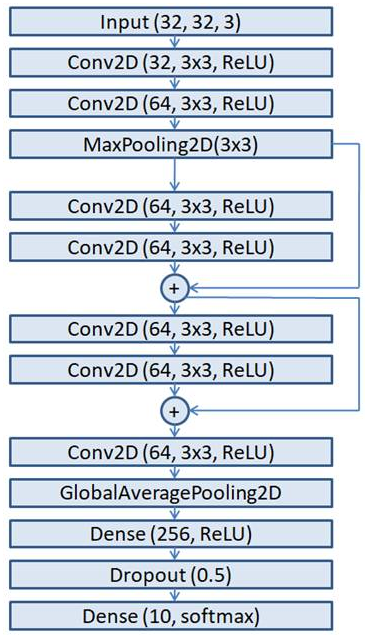

In [12]:
# Формируем первый входной блок
# Слой Inputs берем из первого представления
x31 = Conv2D(32, (3,3), activation="relu", name='x31')(inputs)
x32 = Conv2D(64, (3,3), activation="relu", name='x32')(x31)
block_1_output = MaxPooling2D(pool_size=(3,3))(x32)

In [13]:
# Формируем 1-й обходной блок
x33 = Conv2D(64, (3,3), activation="relu", padding="same", name='x33')(block_1_output)
x34 = Conv2D(64, (3,3), activation="relu", padding="same", name='x34')(x33)

In [14]:
# Формируем точку входа(суммирование) первого блока и обходного
block_2_output = tf.keras.layers.add([x34, block_1_output])

In [15]:
# Формируем 2-й обходной блок
x35 = Conv2D(64, (3,3), activation="relu", padding="same", name='x35')(block_2_output)
x36 = Conv2D(64, (3,3), activation="relu", padding="same", name='x36')(x35)
block_3_output = tf.keras.layers.add([x36, block_2_output])

In [20]:
# Формируем суммарный выходной блок
x37 = Conv2D(64, (3,3), activation="relu", name='x37')(block_3_output)
x38 = GlobalAveragePooling2D()(x37)
x39 = Dense(256, activation="relu", name='x39')(x38)
x310 = Dropout(0.5)(x39)
outputs = Dense(10, activation='softmax')(x310)

In [22]:
# Собираем модель
model3 = Model(inputs, outputs)

In [23]:
# Собираем тестировочный модуль
MyModel['models'] = [model3]
MyModel['optimizers'] = [opt_adam, opt_rmsp, opt_sgd]
MyModel['losses'] = [loss_cce]

In [32]:
# Запускаем подборку
# Подборку выполним с теми же параметрами, что и у предидущих двух моделей
best_model2 = compile_models(MyModel, x_train, x_test, y_train, y_test, model_batch=350, model_epoch=10)

Start
Компиляция модели: Model 1  Optimizer 1  Loss 1  Batch=350  Epochs=10  Metrics=accuracy
Обучение модели: Model 1  Optimizer 1 Loss 1  Batch=350  Epochs=10  Metrics=accuracy
Epoch 1/10
143/143 [==============================] - 143s 994ms/step - loss: 2.3485 - accuracy: 0.1307
Epoch 2/10
143/143 [==============================] - 140s 976ms/step - loss: 1.9563 - accuracy: 0.2266
Epoch 3/10
143/143 [==============================] - 140s 976ms/step - loss: 1.8402 - accuracy: 0.2802
Epoch 4/10
143/143 [==============================] - 140s 977ms/step - loss: 1.7871 - accuracy: 0.3062
Epoch 5/10
143/143 [==============================] - 142s 994ms/step - loss: 1.7196 - accuracy: 0.3405
Epoch 6/10
143/143 [==============================] - 139s 971ms/step - loss: 1.6603 - accuracy: 0.3719
Epoch 7/10
143/143 [==============================] - 138s 967ms/step - loss: 1.5990 - accuracy: 0.4007
Epoch 8/10
143/143 [==============================] - 139s 973ms/step - loss: 1.5484 - accura

In [33]:
best_model2

{'Model_1__Optimizer_3__Loss_1': 0.5425000190734863}

### По результатам подборки для 3-ей модели наблюдается улучшение показателя accuracy до 0.543, что значительно превышает показания при тестирование первых двух моделей. Долее выполним подборку размера batch и количества epoch для 3-ей модели с оптимизатором SGD и функцией потерь CategoricalCrossentropy

In [35]:
# Проверим повлияет ли уменьшение размера подаваемых данных
batch_list = [50, 150, 250]
# И повлияет ли увеличение количества эпох т.к. в последнем тесте наблюдался рост показателя accuracy с каждой новой эпохой
epoch_list = [15, 20]

In [36]:
MyModel['models'] = [model3]
MyModel['optimizers'] = [opt_sgd]
MyModel['losses'] = [loss_cce]

In [38]:
model3.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs (InputLayer)         [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 x31 (Conv2D)                (None, 30, 30, 32)           896       ['inputs[0][0]']              
                                                                                                  
 x32 (Conv2D)                (None, 28, 28, 64)           18496     ['x31[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 9, 9, 64)             0         ['x32[0][0]']                 
 D)                                                                                         

In [37]:
MyModel

{'models': [<keras.src.engine.functional.Functional at 0x7c635d39f4c0>],
 'optimizers': [<keras.src.optimizers.legacy.gradient_descent.SGD at 0x7c635bebd0c0>],
 'losses': [<keras.src.losses.CategoricalCrossentropy at 0x7c635bebd240>]}

In [39]:
def compile_models_improved(Model, X_train, X_test, y_train, y_test, model_batch, model_epoch, model_metrics='accuracy'):
    """Функция осуществляет подбор наилудчшей модели с несколькими оптимизаторами"""
    print("Start")
    start = time.time()
    result_dict = {}
    X_train, X_test = Reshape_2D_to_3D(X_train, X_test)
    for n1, model in enumerate(Model['models']): # Для каждой модели
        n1 += 1
        for n2, model_optimazer in enumerate(Model['optimizers']): # Для каждого оптимизатора
            n2 += 1
            for n3, loss_i in enumerate(Model['losses']): # Для каждой функции потерь
                n3 += 1
                for epoch in model_epoch:
                    for batch in model_batch:
                        # Компиляция модели
                        print(f'Компиляция модели: Model {n1}  Optimizer {n2}  Loss {n3}  Batch={batch}  Epochs={epoch}  Metrics={model_metrics}')
                        model.compile(optimizer=model_optimazer, loss=loss_i, metrics=[model_metrics])
                        # Обучение модели
                        print(f'Обучение модели: Model {n1}  Optimizer {n2} Loss {n3}  Batch={batch}  Epochs={epoch}  Metrics={model_metrics}')
                        model.fit(X_train, y_train, batch_size=batch, epochs=epoch)
                        # Оценка модели
                        print(f'Оценка модели: Model {n1}  Optimizer {n2}  Loss {n3}  Batch={batch}  Epochs={epoch}  Metrics={model_metrics}')
                        test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=0)
                        # Запись результатов оценки модели в словарь
                        # Лучшая модель будет определяться по наибольшемы результату метрики accuracy
                        print(f'Запись результатов: Model {n1}  Optimizer {n2}  Loss {n3}  Batch={batch}  Epochs={epoch}  Metrics={model_metrics}')
                        print("*"*90)
                        result_dict[f'Model_{n1}__Optimizer_{n2}__Loss_{n3}__Batch={batch}__Epochs={epoch}'] = test_acc

    model_keys_list = list(result_dict.keys())
    model_values_list = list(result_dict.values())

    best_accuracy = max(model_values_list)
    count_best_accuracy = model_values_list.count(best_accuracy)

    best_model_dict = {}

    print('Определение наилудчшей модели')
    for acc in range(count_best_accuracy):
        model_keys_list = list(result_dict.keys())
        model_values_list = list(result_dict.values())
        if best_accuracy in model_values_list:
            acc_index = model_values_list.index(best_accuracy)
            best_model_dict[model_keys_list[acc_index]] = best_accuracy
            result_dict.pop(model_keys_list[acc_index])
        else:
            break
    stop = time.time()
    print("Time", stop - start)
    return best_model_dict

In [43]:
best_model3 = compile_models_improved(MyModel, x_train, x_test, y_train, y_test, batch_list, epoch_list)

Start
Компиляция модели: Model 1  Optimizer 1  Loss 1  Batch=50  Epochs=15  Metrics=accuracy
Обучение модели: Model 1  Optimizer 1 Loss 1  Batch=50  Epochs=15  Metrics=accuracy
Epoch 1/15
1000/1000 [==============================] - 140s 139ms/step - loss: 1.3443 - accuracy: 0.5170
Epoch 2/15
1000/1000 [==============================] - 141s 141ms/step - loss: 1.3216 - accuracy: 0.5237
Epoch 3/15
1000/1000 [==============================] - 140s 140ms/step - loss: 1.3133 - accuracy: 0.5264
Epoch 4/15
1000/1000 [==============================] - 140s 140ms/step - loss: 1.3142 - accuracy: 0.5276
Epoch 5/15
1000/1000 [==============================] - 142s 142ms/step - loss: 1.3072 - accuracy: 0.5273
Epoch 6/15
1000/1000 [==============================] - 140s 140ms/step - loss: 1.2984 - accuracy: 0.5317
Epoch 7/15
1000/1000 [==============================] - 140s 140ms/step - loss: 1.2968 - accuracy: 0.5327
Epoch 8/15
1000/1000 [==============================] - 139s 139ms/step - loss: 1

In [44]:
best_model3

{'Model_1__Optimizer_1__Loss_1__Batch=250__Epochs=20': 0.5852000117301941}

In [45]:
probability_model = tf.keras.Sequential([model3, tf.keras.layers.Softmax()])
predictions = probability_model.predict(x_test, verbose=0)
y_pred = np.argmax(predictions, axis=1)

In [65]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

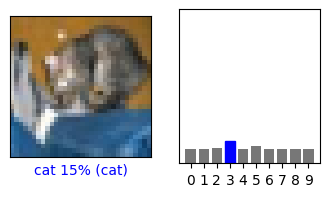

In [72]:
i = 0
plt.figure(figsize=(4,2))
plt.subplot(1,2,1)
plot_image(i, predictions[i], y_test, x_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  y_test)
plt.show()

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


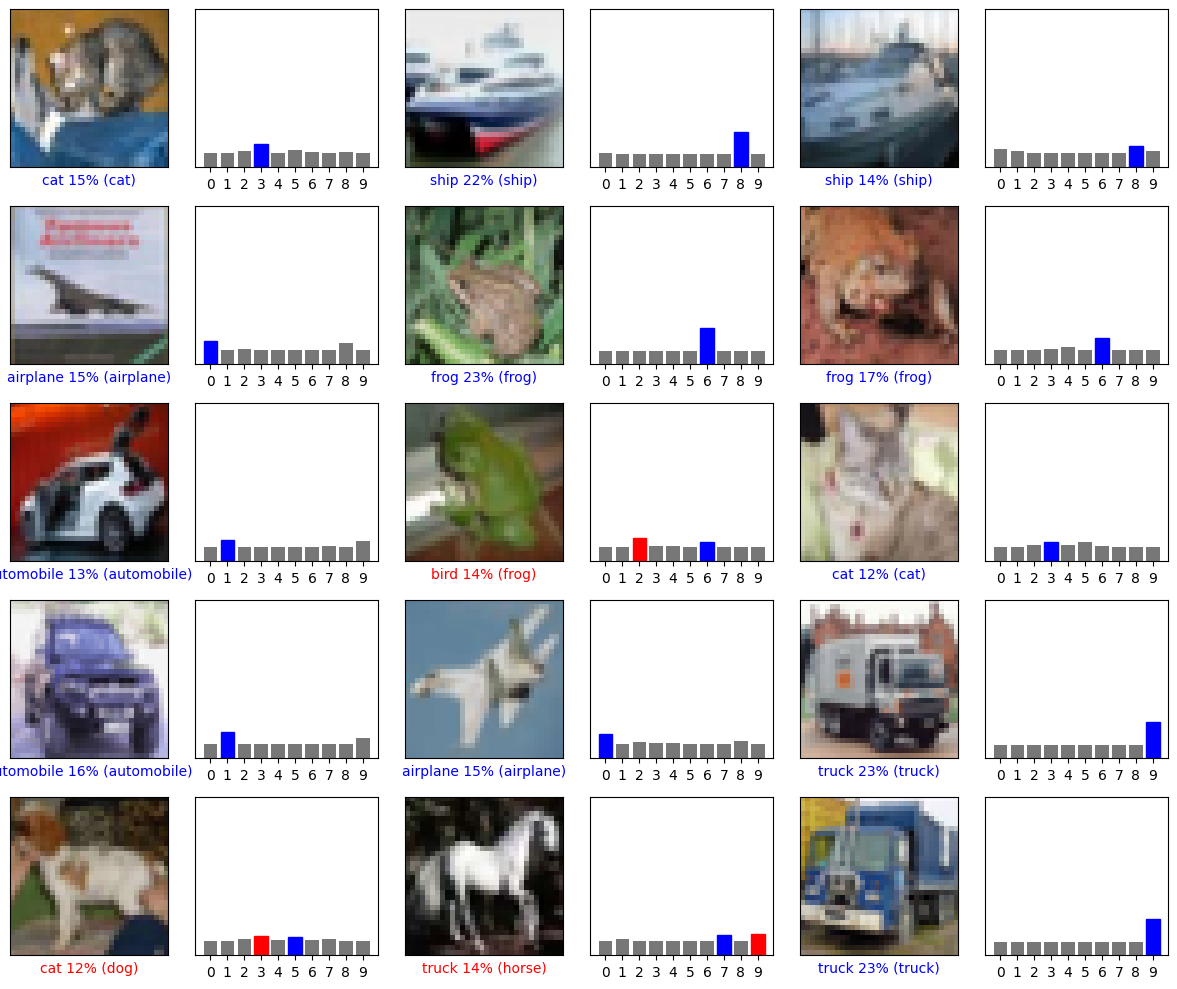

In [71]:
print(class_names)
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], y_test, x_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()

По итогам тестирования 3-х моделей и подбора параметров batch_size и epochs Была выбрана модель 3(схожая по строению с ResNet) batch_size 250 и количество эпох 20. Из тестирования последней модели и подбору для неё параметров очень хорошо просматривается улучшение показателя accuracy с увеличением количества эпох, параметр batch_size оказывает менее положительное влияние на результат.